In [1]:
pip install python-dotenv

In [2]:
import pandas as pd
import os
from dotenv import load_dotenv
import numpy
import requests
import json
import datetime
import dateutil.parser
import pytz
from typing import Optional, Union
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# An api key is emailed to you when you sign up to a plan
# Get a free API key at https://api.the-odds-api.com/

load_dotenv()
API_KEY = os.getenv('API_KEY')

SPORT = 'upcoming' # use the sport_key from the /sports endpoint below, or use 'upcoming' to see the next 8 games across all sports

REGIONS = 'us' # uk | us | eu | au. Multiple can be specified if comma delimited

MARKETS = 'h2h' # h2h | spreads | totals. Multiple can be specified if comma delimited

ODDS_FORMAT = 'american' # decimal | american

DATE_FORMAT = 'iso' # iso | unix

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# First get a list of in-season sports
#   The sport 'key' from the response can be used to get odds in the next request
#
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

sports_response = requests.get(
    'https://api.the-odds-api.com/v4/sports',
    params={
        'api_key': API_KEY
    }
)


if sports_response.status_code != 200:
    print(f'Failed to get sports: status_code {sports_response.status_code}, response body {sports_response.text}')

else:
    print('List of in season sports:', sports_response.json())


List of in season sports: [{'key': 'americanfootball_cfl', 'group': 'American Football', 'title': 'CFL', 'description': 'Canadian Football League', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_ncaaf', 'group': 'American Football', 'title': 'NCAAF', 'description': 'US College Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_ncaaf_championship_winner', 'group': 'American Football', 'title': 'NCAAF Championship Winner', 'description': 'US College Football Championship Winner', 'active': True, 'has_outrights': True}, {'key': 'americanfootball_nfl', 'group': 'American Football', 'title': 'NFL', 'description': 'US Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_nfl_preseason', 'group': 'American Football', 'title': 'NFL Preseason', 'description': 'US Football', 'active': True, 'has_outrights': False}, {'key': 'americanfootball_nfl_super_bowl_winner', 'group': 'American Football', 'title': 'NFL Super Bowl Winner'

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#
# Now get a list of live & upcoming games for the sport you want, along with odds for different bookmakers
# This will deduct from the usage quota
# The usage quota cost = [number of markets specified] x [number of regions specified]
# For examples of usage quota costs, see https://the-odds-api.com/liveapi/guides/v4/#usage-quota-costs

SPORT = 'baseball_mlb'

odds_response = requests.get(
    f'https://api.the-odds-api.com/v4/sports/{SPORT}/odds',
    params={
        'api_key': API_KEY,
        'regions': REGIONS,
        'markets': MARKETS,
        'oddsFormat': ODDS_FORMAT,
        'dateFormat': DATE_FORMAT,
    }
)

if odds_response.status_code != 200:
    print(f'Failed to get odds: status_code {odds_response.status_code}, response body {odds_response.text}')

else:
    odds_json = odds_response.json()
    print('Number of events:', len(odds_json))
    print(odds_json)


Number of events: 21
[{'id': '151cd311535cea19070ec15d53d5f104', 'sport_key': 'baseball_mlb', 'sport_title': 'MLB', 'commence_time': '2024-08-19T22:41:00Z', 'home_team': 'Miami Marlins', 'away_team': 'Arizona Diamondbacks', 'bookmakers': [{'key': 'fanduel', 'title': 'FanDuel', 'last_update': '2024-08-19T18:24:30Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-19T18:24:30Z', 'outcomes': [{'name': 'Arizona Diamondbacks', 'price': -205}, {'name': 'Miami Marlins', 'price': 172}]}]}, {'key': 'betmgm', 'title': 'BetMGM', 'last_update': '2024-08-19T18:26:06Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-19T18:26:06Z', 'outcomes': [{'name': 'Arizona Diamondbacks', 'price': -210}, {'name': 'Miami Marlins', 'price': 170}]}]}, {'key': 'bovada', 'title': 'Bovada', 'last_update': '2024-08-19T18:26:06Z', 'markets': [{'key': 'h2h', 'last_update': '2024-08-19T18:26:06Z', 'outcomes': [{'name': 'Arizona Diamondbacks', 'price': -211}, {'name': 'Miami Marlins', 'price': 171}]}]}, {'key': 'dra

In [6]:
# Check the usage quota
print('Remaining requests', odds_response.headers['x-requests-remaining'])
print('Used requests', odds_response.headers['x-requests-used'])


Remaining requests 477
Used requests 23


In [7]:
#set up the columns
columns = [
        'event_id', 'sport_key', 'sport_title', 'commence_time',
        'home_team', 'away_team', 'bookmaker_key', 'bookmaker_title',
        'bookmaker_last_update', 'market_key', 'market_last_update',
        'outcome_name', 'outcome_price']

df2 = pd.DataFrame(columns=columns)

# Prepare list to collect all rows
all_rows = []

# Iterate over each event
for event in odds_json:
        event_id = event['id']
        sport_key = event['sport_key']
        sport_title = event['sport_title']
        commence_time = event['commence_time']
        home_team = event['home_team']
        away_team = event['away_team']

        # Iterate over each bookmaker
        for bookmaker in event['bookmakers']:
            bookmaker_key = bookmaker['key']
            bookmaker_title = bookmaker['title']
            bookmaker_last_update = bookmaker['last_update']

            # Iterate over each market
            for market in bookmaker['markets']:
                market_key = market['key']
                market_last_update = market['last_update']

                # Iterate over each outcome
                for outcome in market['outcomes']:
                    outcome_name = outcome['name']
                    outcome_price = outcome['price']

                    # Append the row to the list
                    all_rows.append([
                        event_id, sport_key, sport_title, commence_time,
                        home_team, away_team, bookmaker_key, bookmaker_title,
                        bookmaker_last_update, market_key, market_last_update,
                        outcome_name, outcome_price
                    ])
for i, row in enumerate(all_rows):
    df2.loc[i] = row

In [8]:
df2

,event_id,sport_key,sport_title,commence_time,home_team,away_team,bookmaker_key,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,151cd311535cea19070ec15d53d5f104,baseball_mlb,MLB,2024-08-19T22:41:00Z,Miami Marlins,Arizona Diamondbacks,fanduel,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Arizona Diamondbacks,-205
1,151cd311535cea19070ec15d53d5f104,baseball_mlb,MLB,2024-08-19T22:41:00Z,Miami Marlins,Arizona Diamondbacks,fanduel,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Miami Marlins,172
2,151cd311535cea19070ec15d53d5f104,baseball_mlb,MLB,2024-08-19T22:41:00Z,Miami Marlins,Arizona Diamondbacks,betmgm,BetMGM,2024-08-19T18:26:06Z,h2h,2024-08-19T18:26:06Z,Arizona Diamondbacks,-210
3,151cd311535cea19070ec15d53d5f104,baseball_mlb,MLB,2024-08-19T22:41:00Z,Miami Marlins,Arizona Diamondbacks,betmgm,BetMGM,2024-08-19T18:26:06Z,h2h,2024-08-19T18:26:06Z,Miami Marlins,170
4,151cd311535cea19070ec15d53d5f104,baseball_mlb,MLB,2024-08-19T22:41:00Z,Miami Marlins,Arizona Diamondbacks,bovada,Bovada,2024-08-19T18:26:06Z,h2h,2024-08-19T18:26:06Z,Arizona Diamondbacks,-211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,517bc17030b88f1cef3d2c42f32f542e,baseball_mlb,MLB,2024-08-21T01:41:00Z,Oakland Athletics,Tampa Bay Rays,fanduel,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Tampa Bay Rays,-124
218,dacf4a20f1d8e289de1d5f33fbab0a68,baseball_mlb,MLB,2024-08-21T01:46:00Z,San Francisco Giants,Chicago White Sox,fanduel,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Chicago White Sox,220
219,dacf4a20f1d8e289de1d5f33fbab0a68,baseball_mlb,MLB,2024-08-21T01:46:00Z,San Francisco Giants,Chicago White Sox,fanduel,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,San Francisco Giants,-270
220,c3dc1307004884e4f4138be14bbd2fe6,baseball_mlb,MLB,2024-08-21T02:11:00Z,Los Angeles Dodgers,Seattle Mariners,fanduel,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Los Angeles Dodgers,-142


In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, 0 to 221
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   event_id               222 non-null    object
 1   sport_key              222 non-null    object
 2   sport_title            222 non-null    object
 3   commence_time          222 non-null    object
 4   home_team              222 non-null    object
 5   away_team              222 non-null    object
 6   bookmaker_key          222 non-null    object
 7   bookmaker_title        222 non-null    object
 8   bookmaker_last_update  222 non-null    object
 9   market_key             222 non-null    object
 10  market_last_update     222 non-null    object
 11  outcome_name           222 non-null    object
 12  outcome_price          222 non-null    int64 
dtypes: int64(1), object(12)
memory usage: 32.4+ KB


In [10]:
df2.duplicated().sum()

0

In [11]:
df2.duplicated().value_counts()

,count
False,222


In [12]:
df2.drop_duplicates(inplace=True)

In [13]:
df2.duplicated().sum()

0

In [14]:
df2.isnull().sum()

,0
event_id,0
sport_key,0
sport_title,0
commence_time,0
home_team,0
away_team,0
bookmaker_key,0
bookmaker_title,0
bookmaker_last_update,0
market_key,0


In [15]:
df2= df2.drop(columns = ['event_id', 'commence_time', 'bookmaker_key'])
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Arizona Diamondbacks,-205
1,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Miami Marlins,172
2,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,BetMGM,2024-08-19T18:26:06Z,h2h,2024-08-19T18:26:06Z,Arizona Diamondbacks,-210
3,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,BetMGM,2024-08-19T18:26:06Z,h2h,2024-08-19T18:26:06Z,Miami Marlins,170
4,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,Bovada,2024-08-19T18:26:06Z,h2h,2024-08-19T18:26:06Z,Arizona Diamondbacks,-211
...,...,...,...,...,...,...,...,...,...,...
217,baseball_mlb,MLB,Oakland Athletics,Tampa Bay Rays,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Tampa Bay Rays,-124
218,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Chicago White Sox,220
219,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,San Francisco Giants,-270
220,baseball_mlb,MLB,Los Angeles Dodgers,Seattle Mariners,FanDuel,2024-08-19T18:24:30Z,h2h,2024-08-19T18:24:30Z,Los Angeles Dodgers,-142


In [16]:
# Convert the columns to datetime
df2['bookmaker_last_update'] = pd.to_datetime(df2['bookmaker_last_update'])
df2['market_last_update'] = pd.to_datetime(df2['market_last_update'])

# Format the datetime columns
df2['bookmaker_last_update'] = df2['bookmaker_last_update'].dt.strftime('%b %d, %H:%M')
df2['market_last_update'] = df2['market_last_update'].dt.strftime('%b %d, %H:%M')
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price
0,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Arizona Diamondbacks,-205
1,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Miami Marlins,172
2,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,BetMGM,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Arizona Diamondbacks,-210
3,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,BetMGM,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Miami Marlins,170
4,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,Bovada,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Arizona Diamondbacks,-211
...,...,...,...,...,...,...,...,...,...,...
217,baseball_mlb,MLB,Oakland Athletics,Tampa Bay Rays,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Tampa Bay Rays,-124
218,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Chicago White Sox,220
219,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",San Francisco Giants,-270
220,baseball_mlb,MLB,Los Angeles Dodgers,Seattle Mariners,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Los Angeles Dodgers,-142


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, 0 to 221
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sport_key              222 non-null    object
 1   sport_title            222 non-null    object
 2   home_team              222 non-null    object
 3   away_team              222 non-null    object
 4   bookmaker_title        222 non-null    object
 5   bookmaker_last_update  222 non-null    object
 6   market_key             222 non-null    object
 7   market_last_update     222 non-null    object
 8   outcome_name           222 non-null    object
 9   outcome_price          222 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 27.2+ KB


In [18]:
def av_odds(df2):
    # Define key columns for grouping
    key_fields = ['home_team', 'away_team', 'bookmaker_title', 'outcome_name']

    # Perform aggregation by calculating the average outcome_price
    df_avg = df2.groupby(key_fields, dropna=False).agg({
        'outcome_price': 'mean'  # Average outcome_price
    }).reset_index()

    # Sort the aggregated DataFrame by key fields
    df_avg.sort_values(['home_team','away_team'], inplace=True)

    return df_avg



In [19]:
df_avg_odds = av_odds(df2)
df_avg_odds

,home_team,away_team,bookmaker_title,outcome_name,outcome_price
0,Houston Astros,Boston Red Sox,BetMGM,Boston Red Sox,120.0
1,Houston Astros,Boston Red Sox,BetMGM,Houston Astros,-145.0
2,Houston Astros,Boston Red Sox,BetOnline.ag,Boston Red Sox,134.0
3,Houston Astros,Boston Red Sox,BetOnline.ag,Houston Astros,-146.0
4,Houston Astros,Boston Red Sox,BetRivers,Boston Red Sox,120.0
...,...,...,...,...,...
201,Toronto Blue Jays,Cincinnati Reds,LowVig.ag,Toronto Blue Jays,-165.0
202,Toronto Blue Jays,Cincinnati Reds,MyBookie.ag,Cincinnati Reds,148.0
203,Toronto Blue Jays,Cincinnati Reds,MyBookie.ag,Toronto Blue Jays,-175.0
204,Washington Nationals,Colorado Rockies,FanDuel,Colorado Rockies,120.0


In [20]:
#general average odds for the home team only
avg_odds = df2.groupby('home_team')['outcome_price'].mean()
avg_odds

,outcome_price
home_team,
Houston Astros,-10.000000
Kansas City Royals,-19.409091
Los Angeles Dodgers,-9.090909
Miami Marlins,-15.400000
New York Mets,-17.863636
New York Yankees,-12.000000
Oakland Athletics,-8.500000
San Diego Padres,-19.500000
San Francisco Giants,-20.181818


In [21]:
# top 5 highest standard deviation.A higher SD indicates a mix of very high and very low vigors
std_dev_odds = df2.groupby('outcome_name')['outcome_price'].std()
std_dev_odds.nlargest(5)

,outcome_price
outcome_name,
Minnesota Twins,74.918744
Baltimore Orioles,66.696054
Kansas City Royals,16.591345
San Diego Padres,16.426143
Los Angeles Angels,12.901726


In [22]:
#Lower standard deviation indicates vigors more closely consistent with each other.
std_dev_odds.nsmallest(5)

,outcome_price
outcome_name,
Seattle Mariners,2.723634
Oakland Athletics,2.873072
Cincinnati Reds,3.107339
Miami Marlins,4.087923
Toronto Blue Jays,4.408325


In [23]:
#min and max odds sorted by outcome_price
min_odds = df2.groupby('outcome_name')['outcome_price'].min().sort_values()
max_odds = df2.groupby('outcome_name')['outcome_price'].max().sort_values(ascending=False)

print("**Minimum Odds:**")
print(min_odds)
print("")
print("**Maximum Odds:**")
print(max_odds)

**Minimum Odds:**
outcome_name
San Francisco Giants   -270
Kansas City Royals     -250
Arizona Diamondbacks   -211
Toronto Blue Jays      -175
Texas Rangers          -163
San Diego Padres       -162
New York Yankees       -158
Houston Astros         -153
New York Mets          -145
Los Angeles Dodgers    -145
Washington Nationals   -142
St. Louis Cardinals    -138
Tampa Bay Rays         -132
Minnesota Twins        -112
Baltimore Orioles      -104
Oakland Athletics       104
Boston Red Sox          108
Seattle Mariners        111
Pittsburgh Pirates      112
Milwaukee Brewers       118
Colorado Rockies        120
Cleveland Guardians     134
Cincinnati Reds         142
Los Angeles Angels      160
Miami Marlins           165
Chicago White Sox       195
Name: outcome_price, dtype: int64

**Maximum Odds:**
outcome_name
Chicago White Sox       220
Los Angeles Angels      206
Miami Marlins           178
Cincinnati Reds         151
Minnesota Twins         141
Pittsburgh Pirates      137
Boston 

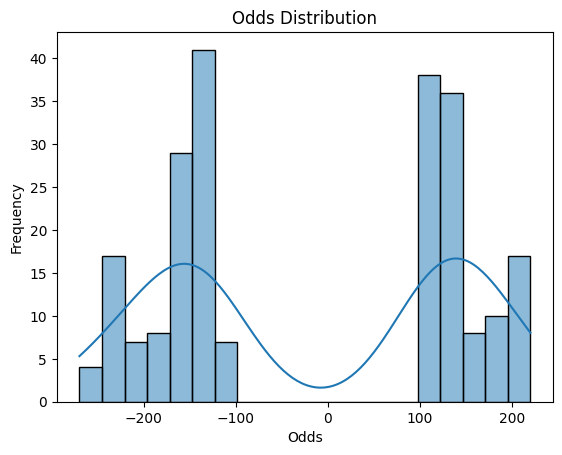

In [24]:
#number of times each team is placed within the odds
sns.histplot(df2['outcome_price'], bins=20, kde=True)
plt.xlabel('Odds')
plt.ylabel('Frequency')
plt.title('Odds Distribution')
plt.show()


In [ ]:
home_odds = df2[df2['home_team'] == 'TeamName']['outcome_price'].mean()
away_odds = df2[df2['away_team'] == 'TeamName']['outcome_price'].mean()
print(home_odds)
print(away_odds)

nan
nan


In [25]:
# Grouping by 'bookmaker_title' and including 'home_team'
bookmaker_odds = df2.groupby(['bookmaker_title', 'home_team'])['outcome_price'].apply(list).reset_index()

# Display the odds
bookmaker_odds


,bookmaker_title,home_team,outcome_price
0,BetMGM,Houston Astros,"[120, -145]"
1,BetMGM,Kansas City Royals,"[-250, 200]"
2,BetMGM,Los Angeles Dodgers,"[-145, 120]"
3,BetMGM,Miami Marlins,"[-210, 170]"
4,BetMGM,New York Mets,"[120, -145]"
...,...,...,...
98,MyBookie.ag,Oakland Athletics,"[112, -132]"
99,MyBookie.ag,San Diego Padres,"[135, -159]"
100,MyBookie.ag,San Francisco Giants,"[198, -238]"
101,MyBookie.ag,Texas Rangers,"[129, -152]"


In [26]:
def calculate_implied_probability(odd):
    if odd < 0:
        return ((-1 * odd) / ((-1 * odd) + 100)) * 100
    else:
        return (100 / (odd + 100)) * 100

In [27]:
# Apply the function to calculate implied probability and add it to the DataFrame
df2['implied_probability'] = df2['outcome_price'].apply(calculate_implied_probability)
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability
0,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Arizona Diamondbacks,-205,67.213115
1,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Miami Marlins,172,36.764706
2,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,BetMGM,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Arizona Diamondbacks,-210,67.741935
3,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,BetMGM,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Miami Marlins,170,37.037037
4,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,Bovada,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Arizona Diamondbacks,-211,67.845659
...,...,...,...,...,...,...,...,...,...,...,...
217,baseball_mlb,MLB,Oakland Athletics,Tampa Bay Rays,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Tampa Bay Rays,-124,55.357143
218,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Chicago White Sox,220,31.250000
219,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",San Francisco Giants,-270,72.972973
220,baseball_mlb,MLB,Los Angeles Dodgers,Seattle Mariners,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Los Angeles Dodgers,-142,58.677686


In [28]:
#A high implied probability and low vigor increases the probable outcome.
def calculate_vigor(row):
    home_team_implied_prob = df2[(df2['bookmaker_title'] == row['bookmaker_title']) & (df2['outcome_name'] == row['home_team'])]['implied_probability'].values[0]
    away_team_implied_prob = df2[(df2['bookmaker_title'] == row['bookmaker_title']) & (df2['outcome_name'] == row['away_team'])]['implied_probability'].values[0]
    vigor = home_team_implied_prob + away_team_implied_prob - 100
    return f"{vigor:.2f}%"

#Apply the function to calculate overround for each bookmaker
df2['vigor'] = df2.apply(calculate_vigor, axis=1)
df2

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability,vigor
0,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Arizona Diamondbacks,-205,67.213115,3.98%
1,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Miami Marlins,172,36.764706,3.98%
2,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,BetMGM,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Arizona Diamondbacks,-210,67.741935,4.78%
3,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,BetMGM,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Miami Marlins,170,37.037037,4.78%
4,baseball_mlb,MLB,Miami Marlins,Arizona Diamondbacks,Bovada,"Aug 19, 18:26",h2h,"Aug 19, 18:26",Arizona Diamondbacks,-211,67.845659,4.75%
...,...,...,...,...,...,...,...,...,...,...,...,...
217,baseball_mlb,MLB,Oakland Athletics,Tampa Bay Rays,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Tampa Bay Rays,-124,55.357143,4.07%
218,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Chicago White Sox,220,31.250000,4.15%
219,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",San Francisco Giants,-270,72.972973,4.15%
220,baseball_mlb,MLB,Los Angeles Dodgers,Seattle Mariners,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Los Angeles Dodgers,-142,58.677686,3.92%


In [29]:
df2['vigor'] = df2['vigor'].str.replace('%', '').astype(float)

In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, 0 to 221
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sport_key              222 non-null    object 
 1   sport_title            222 non-null    object 
 2   home_team              222 non-null    object 
 3   away_team              222 non-null    object 
 4   bookmaker_title        222 non-null    object 
 5   bookmaker_last_update  222 non-null    object 
 6   market_key             222 non-null    object 
 7   market_last_update     222 non-null    object 
 8   outcome_name           222 non-null    object 
 9   outcome_price          222 non-null    int64  
 10  implied_probability    222 non-null    float64
 11  vigor                  222 non-null    float64
dtypes: float64(2), int64(1), object(9)
memory usage: 30.6+ KB


In [31]:
vigor_pivot_table = df2.pivot_table(index='outcome_name', columns='bookmaker_title', values='vigor')
vigor_pivot_table

bookmaker_title,BetMGM,BetOnline.ag,BetRivers,BetUS,Bovada,Caesars,DraftKings,FanDuel,LowVig.ag,MyBookie.ag
outcome_name,,,,,,,,,,
Arizona Diamondbacks,4.78,2.07,3.58,3.70,4.75,4.11,4.25,3.98,2.07,3.95
Baltimore Orioles,4.64,2.15,3.68,1.98,4.36,3.96,4.18,3.56,2.15,4.14
Boston Red Sox,4.64,2.08,3.96,2.64,4.33,4.23,4.32,3.99,2.08,4.16
Chicago White Sox,4.76,2.38,3.92,4.05,4.35,4.37,4.35,4.15,2.38,3.97
Cincinnati Reds,4.45,2.10,4.45,3.08,4.56,4.12,4.45,4.22,2.10,3.96
Cleveland Guardians,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.98,NaN,NaN
Colorado Rockies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN
Houston Astros,4.64,2.08,3.96,2.64,4.33,4.23,4.32,3.99,2.08,4.16
Kansas City Royals,4.76,2.38,4.05,4.18,4.22,4.37,4.35,4.16,2.38,4.26


In [32]:
#Vig from lowest to highest
low_vig = df2[df2['vigor'] <=2.10][['outcome_name', 'vigor','bookmaker_title']].sort_values('vigor')
low_vig

,outcome_name,vigor,bookmaker_title
50,Baltimore Orioles,1.98,BetUS
51,New York Mets,1.98,BetUS
191,Seattle Mariners,1.99,BetUS
190,Los Angeles Dodgers,1.99,BetUS
185,Seattle Mariners,2.01,BetOnline.ag
184,Los Angeles Dodgers,2.01,BetOnline.ag
183,Seattle Mariners,2.01,LowVig.ag
182,Los Angeles Dodgers,2.01,LowVig.ag
79,Texas Rangers,2.05,LowVig.ag
78,Pittsburgh Pirates,2.05,LowVig.ag


In [44]:
#Vig from highest to lowest. a higher vigor leads to larger profit margin for bookmaker, but perceive the game as a higher level of uncertainty.
high_vig = df2[df2['vigor'] >=4.50][['outcome_name', 'vigor','bookmaker_title']].sort_values('vigor', ascending=False)
high_vig

,outcome_name,vigor,bookmaker_title
2,Arizona Diamondbacks,4.78,BetMGM
3,Miami Marlins,4.78,BetMGM
110,Kansas City Royals,4.76,BetMGM
111,Los Angeles Angels,4.76,BetMGM
170,Chicago White Sox,4.76,BetMGM
171,San Francisco Giants,4.76,BetMGM
4,Arizona Diamondbacks,4.75,Bovada
5,Miami Marlins,4.75,Bovada
52,Baltimore Orioles,4.64,BetMGM
53,New York Mets,4.64,BetMGM


In [33]:
#Calculate the vig spread of the highest and lowest bookmaker
df2['vig_spread'] = df2.groupby(['outcome_name'])['vigor'].transform(lambda x: x.max() - x.min())
df2.tail(10)

,sport_key,sport_title,home_team,away_team,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,implied_probability,vigor,vig_spread
212,baseball_mlb,MLB,Kansas City Royals,Los Angeles Angels,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Kansas City Royals,-190,65.517241,4.16,2.38
213,baseball_mlb,MLB,Kansas City Royals,Los Angeles Angels,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Los Angeles Angels,160,38.461538,4.16,2.38
214,baseball_mlb,MLB,San Diego Padres,Minnesota Twins,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Minnesota Twins,-112,52.830189,4.04,2.13
215,baseball_mlb,MLB,San Diego Padres,Minnesota Twins,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",San Diego Padres,-104,50.980392,4.04,2.13
216,baseball_mlb,MLB,Oakland Athletics,Tampa Bay Rays,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Oakland Athletics,106,48.543689,4.07,2.22
217,baseball_mlb,MLB,Oakland Athletics,Tampa Bay Rays,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Tampa Bay Rays,-124,55.357143,4.07,2.22
218,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Chicago White Sox,220,31.250000,4.15,2.38
219,baseball_mlb,MLB,San Francisco Giants,Chicago White Sox,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",San Francisco Giants,-270,72.972973,4.15,2.38
220,baseball_mlb,MLB,Los Angeles Dodgers,Seattle Mariners,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Los Angeles Dodgers,-142,58.677686,3.92,2.65
221,baseball_mlb,MLB,Los Angeles Dodgers,Seattle Mariners,FanDuel,"Aug 19, 18:24",h2h,"Aug 19, 18:24",Seattle Mariners,120,45.454545,3.92,2.65


In [34]:
#highest to smallest vigor spread as percentages
print(df2[['outcome_name', 'vig_spread']].drop_duplicates().sort_values('vig_spread', ascending=False))

             outcome_name  vig_spread
0    Arizona Diamondbacks        2.71
1           Miami Marlins        2.71
40      Baltimore Orioles        2.66
41          New York Mets        2.66
181      Seattle Mariners        2.65
180   Los Angeles Dodgers        2.65
80         Boston Red Sox        2.56
81         Houston Astros        2.56
21      Toronto Blue Jays        2.46
20        Cincinnati Reds        2.46
100    Kansas City Royals        2.38
101    Los Angeles Angels        2.38
160     Chicago White Sox        2.38
161  San Francisco Giants        2.38
140     Oakland Athletics        2.22
141        Tampa Bay Rays        2.22
61          Texas Rangers        2.21
60     Pittsburgh Pirates        2.21
121      San Diego Padres        2.13
120       Minnesota Twins        2.13
200      Colorado Rockies        0.00
201  Washington Nationals        0.00
202   Cleveland Guardians        0.00
203      New York Yankees        0.00
206     Milwaukee Brewers        0.00
207   St. Lo

In [35]:
avg_vig_by_team = df2.groupby('outcome_name')['vigor'].mean()
avg_vig_by_team.nsmallest(5)

,vigor
outcome_name,
Baltimore Orioles,3.487273
New York Mets,3.487273
Los Angeles Dodgers,3.537273
Seattle Mariners,3.537273
Minnesota Twins,3.547273


In [36]:
Implied_pivot_table = df2.pivot_table(index='outcome_name', columns='bookmaker_title', values='implied_probability')
Implied_pivot_table

bookmaker_title,BetMGM,BetOnline.ag,BetRivers,BetUS,Bovada,Caesars,DraftKings,FanDuel,LowVig.ag,MyBookie.ag
outcome_name,,,,,,,,,,
Arizona Diamondbacks,67.741935,66.101695,67.213115,66.666667,67.845659,67.741935,67.213115,67.213115,66.101695,66.216216
Baltimore Orioles,45.454545,45.248869,45.871560,45.454545,46.728972,46.511628,46.728972,48.638344,45.248869,47.619048
Boston Red Sox,45.454545,42.735043,45.454545,43.290043,43.859649,45.045045,44.642857,46.359890,42.735043,44.642857
Chicago White Sox,33.333333,32.679739,33.333333,33.898305,33.333333,33.783784,33.333333,32.403523,32.679739,33.557047
Cincinnati Reds,40.816327,39.840637,40.816327,40.816327,41.322314,41.152263,40.816327,40.983607,39.840637,40.322581
Cleveland Guardians,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.735043,NaN,NaN
Colorado Rockies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.454545,NaN,NaN
Houston Astros,59.183673,59.349593,58.506224,59.349593,60.474308,59.183673,59.677419,57.550903,59.349593,59.514170
Kansas City Royals,71.428571,69.696970,70.149254,69.696970,71.428571,70.588235,71.014493,67.833248,69.696970,70.930233


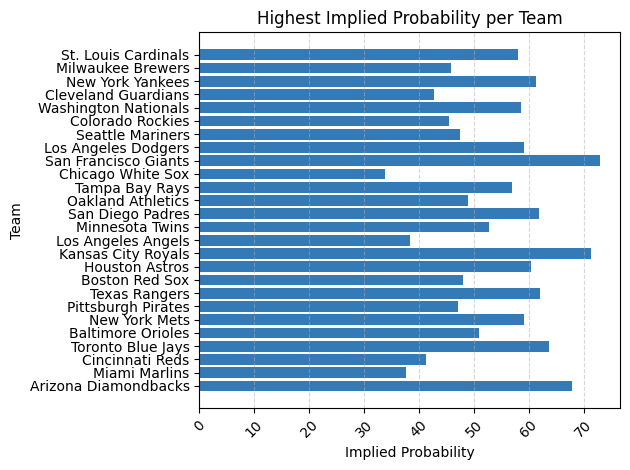

In [37]:
# Assuming the data is in a pandas dataframe called `df`
teams = df2['outcome_name']
implied_probabilities = df2['implied_probability']

plt.barh(teams, implied_probabilities, color='#337ab7')  # blue bars
plt.xlabel('Implied Probability')
plt.ylabel('Team')
plt.title('Highest Implied Probability per Team')
plt.grid(axis='x', linestyle='--', alpha=0.5)  # add a grid
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
plt.tight_layout()  # adjust layout to fit all labels
plt.show()

In [39]:
#Maximum implied probability for all teams sorted from highest to lowest
print(df2.loc[df2.groupby('outcome_name')['implied_probability'].idxmax()].sort_values('implied_probability', ascending=False)[['outcome_name', 'implied_probability']])

             outcome_name  implied_probability
219  San Francisco Giants            72.972973
110    Kansas City Royals            71.428571
4    Arizona Diamondbacks            67.845659
23      Toronto Blue Jays            63.636364
67          Texas Rangers            61.977186
137      San Diego Padres            61.832061
203      New York Yankees            61.240310
95         Houston Astros            60.474308
192   Los Angeles Dodgers            59.183673
53          New York Mets            59.183673
201  Washington Nationals            58.677686
207   St. Louis Cardinals            57.983193
141        Tampa Bay Rays            56.896552
214       Minnesota Twins            52.830189
204     Baltimore Orioles            50.980392
152     Oakland Athletics            49.019608
210        Boston Red Sox            48.076923
195      Seattle Mariners            47.393365
208    Pittsburgh Pirates            47.169811
206     Milwaukee Brewers            45.871560
200      Colo

In [40]:
print(df_avg_odds.head())
print(f'Number of rows in aggregated DataFrame: {df_avg_odds.shape[0]}')


        home_team       away_team bookmaker_title    outcome_name  \
0  Houston Astros  Boston Red Sox          BetMGM  Boston Red Sox   
1  Houston Astros  Boston Red Sox          BetMGM  Houston Astros   
2  Houston Astros  Boston Red Sox    BetOnline.ag  Boston Red Sox   
3  Houston Astros  Boston Red Sox    BetOnline.ag  Houston Astros   
4  Houston Astros  Boston Red Sox       BetRivers  Boston Red Sox   

   outcome_price  
0          120.0  
1         -145.0  
2          134.0  
3         -146.0  
4          120.0  
Number of rows in aggregated DataFrame: 206


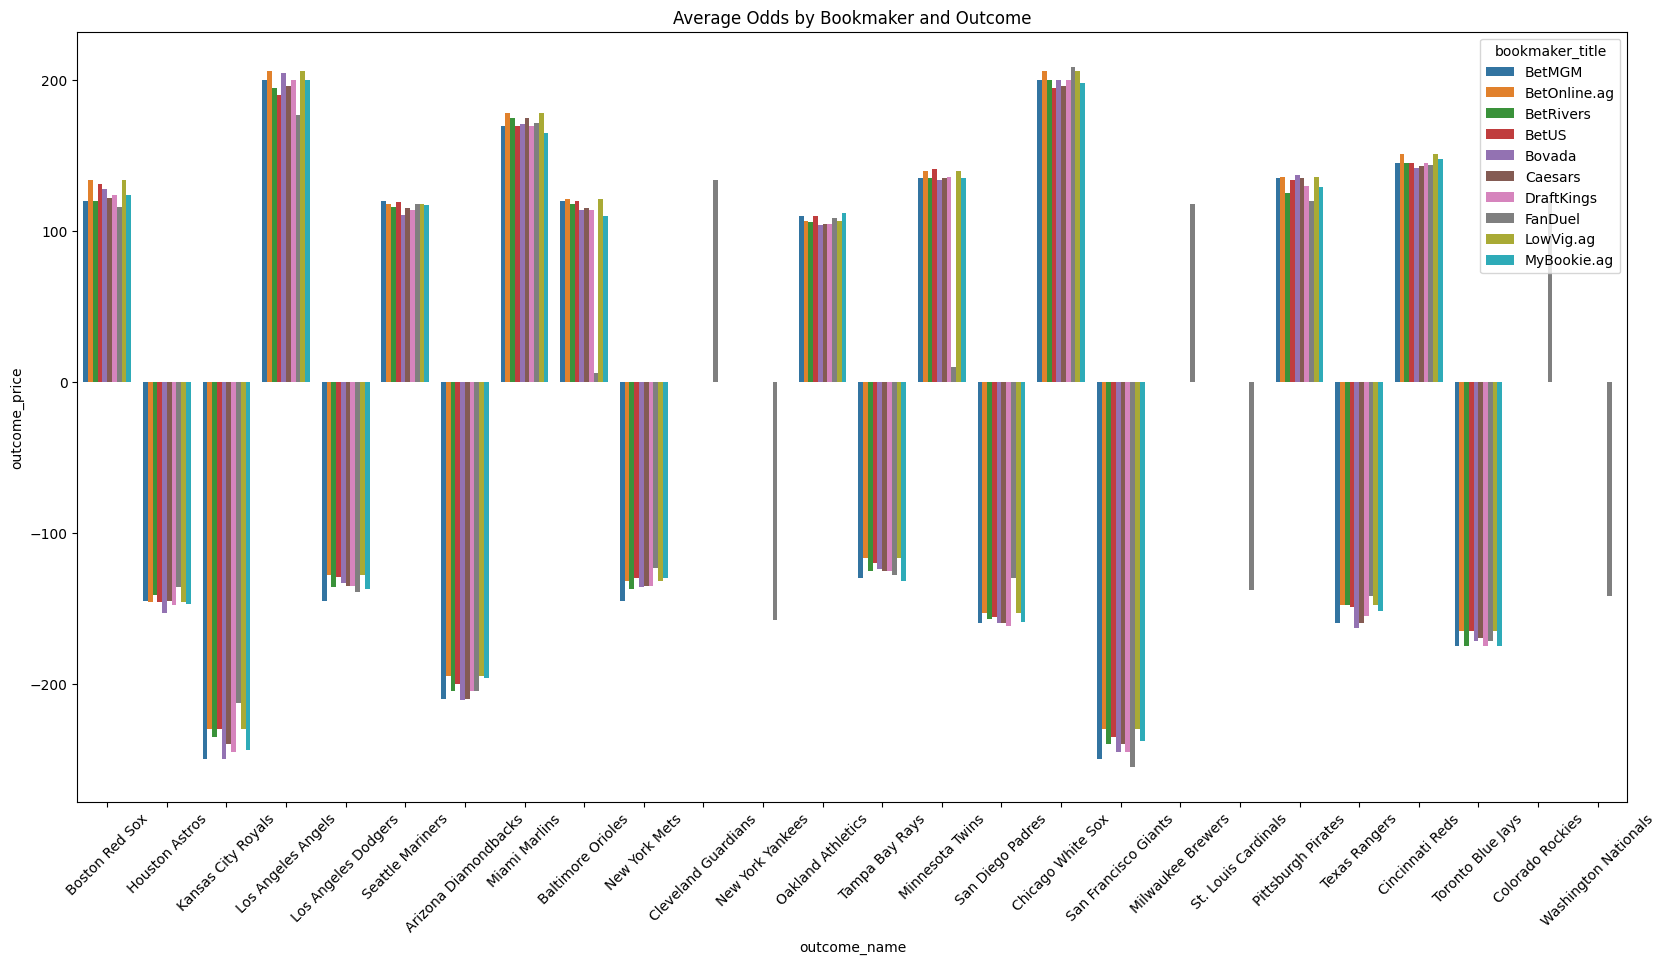

In [41]:
plt.figure(figsize=(20, 10))
sns.barplot(data=df_avg_odds, x='outcome_name', y='outcome_price', hue='bookmaker_title')
plt.title('Average Odds by Bookmaker and Outcome')
plt.xticks(rotation=45)
plt.show()